In [4]:
conda install hydromt -c conda-forge

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import xarray as xr
import glob
import os
import hydromt
from dask.diagnostics import ProgressBar 

In [2]:
# setup logging
from hydromt.log import setuplog
logger = setuplog("read raster data", log_level=10)

2022-04-21 09:52:51,561 - read raster data - log - INFO - HydroMT version: 0.4.5


In [3]:
!hydromt --models

hydroMT model plugins: sfincs (v0.2.1), wflow (v0.1.4), wflow_sediment (v0.1.4)


In [2]:
!hydromt build --help

Usage: hydromt build [OPTIONS] MODEL MODEL_ROOT REGION

  Build models from source data.

  Example usage:
  --------------

  To build a wflow model for a subbasin using and point coordinates snapped to cells with stream order >= 4
  hydromt build wflow /path/to/model_root "{'subbasin': [-7.24, 62.09], 'strord': 4}" -i /path/to/wflow_config.ini

  To build a wflow model based on basin ID
  hydromt build wflow /path/to/model_root "{'basin': 230001006}"

  To build a sfincs model based on a bbox (for Texel)
  hydromt build sfincs /path/to/model_root "{'bbox': [4.6891,52.9750,4.9576,53.1994]}"

Options:
  -r, --res FLOAT             Model resolution in model src.
  --build-base / --build-all  Deprecated!
  --opt TEXT                  Component specific keyword arguments, see the
                              setup_<component> method of the specific model
                              for more information about the arguments.
  -i, --config PATH           Path to hydroMT configuration fil

In [4]:
# Open data using the deltares data catalog
data_catalog = hydromt.DataCatalog(deltares_data=True, logger=logger)
data_catalog

2022-04-21 09:53:00,574 - read raster data - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hydromt-artifacts/releases/download/v0.0.6/deltares_data.yml


,path,data_type,driver,category,paper_doi,paper_ref,source_license,source_url,source_version,source_author,unit,history,notes,source_info,author,timestamp
chelsa,p:\wflow_global\hydromt\meteo\chelsa_clim_v1.2...,RasterDataset,raster,meteo,10.1038/sdata.2017.122,Karger et al. (2017),CC BY 4.0,http://chelsa-climate.org/downloads/,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chelsa_v1.2,p:\wflow_global\hydromt\meteo\chelsa_clim_v1.2...,RasterDataset,raster,meteo,10.1038/sdata.2017.122,Karger et al. (2017),CC BY 4.0,http://chelsa-climate.org/downloads/,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chirps,p:\wflow_global\hydromt\meteo\chirps_africa_da...,RasterDataset,netcdf,meteo,10.1038/sdata.2015.66,Funk et al (2015),CC,https://www.chc.ucsb.edu/data/chirps,v2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chirps_africa_daily_v2.0,p:\wflow_global\hydromt\meteo\chirps_africa_da...,RasterDataset,netcdf,meteo,10.1038/sdata.2015.66,Funk et al (2015),CC,https://www.chc.ucsb.edu/data/chirps,v2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chirps_global,p:\wflow_global\hydromt\meteo\chirps_global_da...,RasterDataset,netcdf,meteo,10.3133/ds832,Funk et al (2014),CC,https://www.chc.ucsb.edu/data/chirps,v2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
worldclim_v2.0,p:\wflow_global\hydromt\meteo\worldclim_v2.0\w...,RasterDataset,netcdf,meteo,10.1002/joc.5086,Fick and Hijmans (2017),NaN,https://www.worldclim.org/data/worldclim21.html,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
worldpop_2020_constrained,p:\wflow_global\hydromt\socio_economic\worldpo...,RasterDataset,raster,socio-economic,10.1371/journal.pone.0107042,Stevens et al. (2015),CC BY 4.0,https://www.worldpop.org/doi/10.5258/SOTON/WP0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
worldpop_2020_UNadj_constrained,p:\wflow_global\hydromt\socio_economic\worldpo...,RasterDataset,raster,socio-economic,10.1371/journal.pone.0107042,Stevens et al. (2015),CC BY 4.0,https://www.worldpop.org/doi/10.5258/SOTON/WP0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wsf_bld_2015,p:\wflow_global\hydromt\infrastructure\wsf\WSF...,RasterDataset,raster,socio-economic,10.1038/s41597-020-00580-5,Marconcini at al (2020),CC0 1.0,https://un-spider.org/links-and-resources/data...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_catalog["era5"]

{'category': 'meteo',
 'data_type': 'RasterDataset',
 'driver': 'netcdf',
 'history': 'Extracted from Copernicus Climate Data Store; resampled by '
            'Deltares to daily frequency',
 'paper_doi': '10.1002/qj.3803',
 'paper_ref': 'Hersbach et al. (2019)',
 'path': 'p:\\wflow_global\\hydromt\\meteo\\era5_daily\\nc_merged\\era5_*_daily.nc',
 'source_license': 'https://cds.climate.copernicus.eu/cdsapp/#!/terms/licence-to-use-copernicus-products',
 'source_url': 'https://doi.org/10.24381/cds.bd0915c6',
 'source_version': 'ERA5 daily data on pressure levels'}

In [11]:
!hydromt build wflow "./wflow_bangkok" "{'subbasin':[100.219387,13.224688,100.829955,13.963184]}" -r 0.00833 --dd -vv

2022-04-20 16:57:49,299 - build - log - DEBUG - Writing log messages to new file C:\Users\beveren\msc_thesis\hydromt_wflow-main\Case_studies\wflow_bangkok\hydromt.log.
2022-04-20 16:57:49,299 - build - log - INFO - HydroMT version: 0.4.5
2022-04-20 16:57:49,299 - build - main - INFO - Building instance of wflow model at C:\Users\beveren\msc_thesis\hydromt_wflow-main\Case_studies\wflow_bangkok.
2022-04-20 16:57:49,299 - build - main - INFO - User settings:
2022-04-20 16:57:49,321 - build - model_plugins - DEBUG - Loaded model plugin 'wflow = hydromt_wflow.wflow.WflowModel' (0.1.4)
2022-04-20 16:57:49,321 - build - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.1.4).
2022-04-20 16:57:49,321 - build - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hydromt-artifacts/releases/download/v0.0.6/deltares_data.yml
2022-04-20 16:57:49,870 - build - model_api - WARNING - Model dir already exists and files might be overwritten: C:\

In [8]:
fn_ini = "wflow_build_bangkok.ini"
with open(fn_ini, "r") as f:
    txt = f.read()
print(txt)

[global]
data_libs       = []            # add optional paths to data yml files

[setup_config]                  # options parsed to wflow ini file <section>.<option>
starttime = 2010-01-01T00:00:00
endtime = 2013-12-31T00:00:00
timestepsecs = 86400
input.path_forcing = inmaps-era5-2010.nc

[setup_basemaps]
hydrography_fn     = merit_hydro   # source hydrography data {merit_hydro, merit_hydro_1k}
basin_index_fn  = merit_hydro_index # source of basin index corresponding to hydrography_fn
upscale_method  = ihu           # upscaling method for flow direction data, by default 'ihu'

[setup_rivers]
hydrography_fn   = merit_hydro      # source hydrography data, should correspond to hydrography_fn in setup_basemaps
river_geom_fn    = rivers_lin2019_v1 # river source data with river width and bankfull discharge
river_upa        = 30               # minimum upstream area threshold for the river map [km2]
rivdph_method    = powlaw           # method to estimate depth {'powlaw', 'manning', 'gvf'}

In [9]:
!hydromt build wflow "./wflow_bangkok" "{'subbasin':[100.219387,13.224688,100.829955,13.963184]}" -r 0.00833 -i wflow_build_bangkok.ini --dd -vv

2022-04-21 10:15:01,509 - build - log - DEBUG - Writing log messages to new file C:\Users\beveren\msc_thesis\hydromt_wflow-main\Case_studies\wflow_bangkok\hydromt.log.
2022-04-21 10:15:01,510 - build - log - INFO - HydroMT version: 0.4.5
2022-04-21 10:15:01,510 - build - main - INFO - Building instance of wflow model at C:\Users\beveren\msc_thesis\hydromt_wflow-main\Case_studies\wflow_bangkok.
2022-04-21 10:15:01,510 - build - main - INFO - User settings:
2022-04-21 10:15:01,546 - build - model_plugins - DEBUG - Loaded model plugin 'wflow = hydromt_wflow.wflow.WflowModel' (0.1.4)
2022-04-21 10:15:01,547 - build - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.1.4).
2022-04-21 10:15:01,547 - build - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hydromt-artifacts/releases/download/v0.0.6/deltares_data.yml
2022-04-21 10:15:02,484 - build - model_api - WARNING - Model dir already exists and files might be overwritten: C:\

2022-04-21 10:24:29,829 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [98.069, 13.458, 101.561, 19.817]
2022-04-21 10:24:29,861 - build - data_adapter - DEBUG - RasterDataset: Convert units for 1 variables.
2022-04-21 10:24:29,871 - build - landuse - INFO - Deriving LAI using average resampling (nodata=255).
2022-04-21 10:24:41,747 - build - model_api - INFO - setup_soilmaps.soil_fn: soilgrids
2022-04-21 10:24:41,748 - build - model_api - INFO - setup_soilmaps.ptf_ksatver: brakensiek
2022-04-21 10:24:41,748 - build - wflow - INFO - Preparing soil parameter maps.
2022-04-21 10:24:41,748 - build - data_adapter - INFO - DataCatalog: Getting soilgrids RasterDataset raster data from p:\wflow_global\hydromt\soil\soilgrids_v1.0\*_250m_ll.tif
2022-04-21 10:24:49,418 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [98.069, 13.458, 101.561, 19.817]
2022-04-21 10:24:49,509 - build - data_adapter - DEBUG - RasterDataset: Convert units for 21 variables.
2022-04-2

[##############                          ] | 37% Completed |  1min  7.7s
[##############                          ] | 37% Completed |  1min  8.5s
[###############                         ] | 37% Completed |  1min  8.6s
[###############                         ] | 37% Completed |  1min  8.7s
[###############                         ] | 37% Completed |  1min  8.8s
[###############                         ] | 37% Completed |  1min  9.0s
[###############                         ] | 38% Completed |  1min  9.1s
[###############                         ] | 38% Completed |  1min  9.2s
[###############                         ] | 38% Completed |  1min  9.3s
[###############                         ] | 38% Completed |  1min  9.4s
[###############                         ] | 38% Completed |  1min 10.6s
[###############                         ] | 38% Completed |  1min 10.7s
[###############                         ] | 38% Completed |  1min 10.8s
[###############                         ] | 38% Co

In [10]:
import os

root = "wflow_bangkok"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

wflow_bangkok
 - hydromt.log
 - hydromt_data.yml
 - inmaps-era5-2010.nc
 - inmaps_era5_era5d_debruin_86400_2010_2010.nc
 - inmaps_era5_era5d_debruin_86400_2010_2013.nc
 - reservoir_accuracy.csv
 - staticmaps.nc
 - wflow_sbm.toml
wflow_bangkok\instate
wflow_bangkok\run_default
wflow_bangkok\staticgeoms
 - basins.geojson
 - gauges.geojson
 - gauges_grdc.geojson
 - region.geojson
 - reservoirs.geojson
 - rivers.geojson


In [3]:
import xarray as xr
import numpy as np
import hydromt
from hydromt_wflow import WflowModel

In [4]:
root = "wflow_bangkok"
mod = WflowModel(root, mode="r")

In [5]:
# plot maps dependencies
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# import descartes  # used under the hood to plot polygons

In [6]:
# read and mask the model elevation
da = mod.staticmaps["wflow_dem"].raster.mask_nodata()
da.attrs.update(long_name="elevation", units="m")
# read/derive river geometries
gdf_riv = mod.rivers
# read/derive model basin boundary
gdf_bas = mod.basins

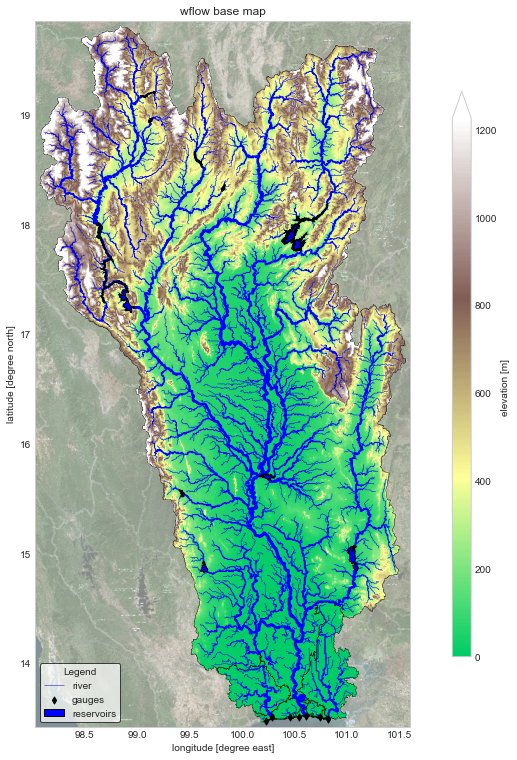

In [7]:
plt.style.use("seaborn-whitegrid")  # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (15,13)
shaded = False  # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = da.raster.box.to_crs(3857).buffer(5e3).to_crs(da.raster.crs).total_bounds
extent = np.array(bbox)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot elevation\
# create nice colormap
vmin, vmax = da.quantile([0.0, 0.98]).compute()
c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
kwargs = dict(cmap=cmap, norm=norm)
# plot 'normal' elevation
da.plot(
    transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=0.8), **kwargs
)
# plot elevation with shades
if shaded:
    ls = colors.LightSource(azdeg=315, altdeg=45)
    dx, dy = da.raster.res
    _rgb = ls.shade(
        da.fillna(0).values,
        norm=kwargs["norm"],
        cmap=kwargs["cmap"],
        blend_mode="soft",
        dx=dx,
        dy=dy,
        vert_exag=200,
    )
    rgb = xr.DataArray(dims=("y", "x", "rgb"), data=_rgb, coords=da.raster.coords)
    rgb = xr.where(np.isnan(da), np.nan, rgb)
    rgb.plot.imshow(transform=proj, ax=ax, zorder=2)

# plot rivers with increasing width with stream order
gdf_riv.plot(
    ax=ax, linewidth=gdf_riv["strord"] / 2, color="blue", zorder=3, label="river"
)
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color="k", linewidth=0.3)
# plot various vector layers if present
if "gauges" in mod.staticgeoms:
    mod.staticgeoms["gauges"].plot(
        ax=ax, marker="d", markersize=25, facecolor="k", zorder=5, label="gauges"
    )
patches = (
    []
)  # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
if "lakes" in mod.staticgeoms:
    kwargs = dict(facecolor="lightblue", edgecolor="black", linewidth=1, label="lakes")
    mod.staticgeoms["lakes"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "reservoirs" in mod.staticgeoms:
    kwargs = dict(facecolor="blue", edgecolor="black", linewidth=1, label="reservoirs")
    mod.staticgeoms["reservoirs"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "glaciers" in mod.staticgeoms:
    kwargs = dict(facecolor="grey", edgecolor="grey", linewidth=1, label="glaciers")
    mod.staticgeoms["glaciers"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"wflow base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0], *patches],
    title="Legend",
    loc="lower left",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)

# save figure
# NOTE create figs folder in model root if it does not exist
# fn_out = join(mod.root, "figs", "basemap.png")
# plt.savefig(fn_out, dpi=225, bbox_inches="tight")